# LSTMプラスDropoutをする

In [78]:
import csv
import pathlib
import operator
import json
import numpy as np
import matplotlib.pyplot as plt
# 訓練用データ(train)テスト用データ(test)を分ける　train_test_split
# k分割交差検証を行うKFoldをインストール
from sklearn.model_selection import train_test_split, KFold
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics, callbacks


In [79]:
# データの読み込み datasは降順のデータ

# データセットのパス
file_path = "dataset/csgo_dataset3.csv"

# データを入れる配列変数
datas = list()
# desc_datas = list()
# 昇順ファイルの読み込み
with open(file_path, "r") as f:
    
    r = csv.reader(f)  # rに読み込んだcsvを入れている

    # 読み込んだデータセットをitemsに読み込んでいる
    # next関数では１行目の要素名の読み込みをしない様にできる
    # イテレータ(iter)は要素を一つずつ取り出せる

    items = next(iter(r)) #itemsの0行目に要素名を入れている
    items[0] = items[0][1:] 

    # rはデータ数　Rはデータ数分を繰り返す
    # データを一月分ずらすことで、次の月を出している
    for i, R in enumerate(r):
        if i == 0: 
            tmp = float(R[5])
            continue
            
        # datasに各要素の内容である数値を入れている
        datas.append({
            I:V for I, V in zip(items, map(float, R))
        })
        datas[-1]["avg"] = tmp
        tmp = float(R[5])


datas = list(reversed(datas))

datas

[{'year': 2014.0,
  'month': 1.0,
  'avg': 187047218.0,
  'gain': 8839.08,
  'price': 0.0,
  'steam_online': 215374048.0},
 {'year': 2014.0,
  'month': 2.0,
  'avg': 203940245.0,
  'gain': 4164.01,
  'price': 0.0,
  'steam_online': 187047218.0},
 {'year': 2014.0,
  'month': 3.0,
  'avg': 191717596.0,
  'gain': 10351.96,
  'price': 0.0,
  'steam_online': 203940245.0},
 {'year': 2014.0,
  'month': 4.0,
  'avg': 200047568.0,
  'gain': 8737.2,
  'price': 0.0,
  'steam_online': 191717596.0},
 {'year': 2014.0,
  'month': 5.0,
  'avg': 207131104.0,
  'gain': 6044.49,
  'price': 0.0,
  'steam_online': 200047568.0},
 {'year': 2014.0,
  'month': 6.0,
  'avg': 209067723.0,
  'gain': -761.4,
  'price': 0.0,
  'steam_online': 207131104.0},
 {'year': 2014.0,
  'month': 7.0,
  'avg': 202543340.0,
  'gain': 21974.38,
  'price': 0.0,
  'steam_online': 209067723.0},
 {'year': 2014.0,
  'month': 8.0,
  'avg': 202281291.0,
  'gain': 27047.79,
  'price': 0.0,
  'steam_online': 202543340.0},
 {'year': 2014.

In [80]:
# 割合gainを-100%~100%の間に修正する
for i in range(len(datas)):
    datas[i]["gain"] = (datas[i - 1]["avg"] / datas[i]["avg"]) - 1
    # print(datas[i]["avg"] , datas[i - 1]["avg"], datas[i]["gain"])

# datas[0:13]
# len(datas)
    

In [25]:
mean_items, std_items

({'year': 2017.96261682243,
  'month': 6.4485981308411215,
  'avg': 488618592.8598131,
  'gain': 0.02401475523517152,
  'price': 565.7663551401869,
  'steam_online': 482132167.1214953},
 {'year': 2.5647693366794626,
  'month': 3.4267601244689874,
  'avg': 200757958.89883885,
  'gain': 0.3798291852044349,
  'price': 654.3025762580565,
  'steam_online': 198253770.00640947})

In [81]:
# データの標準化

# データの平均
mean_items = {
    I: np.average([D[I] for D in datas])  for I in items
}
# データの標準偏差
std_items = {
    I: np.std([D[I] for D in datas])  for I in items
}
# データの標準化
standardization_datas = [
    {I:(D[I] - mean_items[I]) / std_items[I] for I in items} for D in datas
]

standardization_datas

[{'year': -1.5450187920447571,
  'month': -1.5900144547425652,
  'avg': -1.5021639815125523,
  'gain': 10.104475516687174,
  'price': -0.8646861187308683,
  'steam_online': -1.3455386957477333},
 {'year': -1.5450187920447571,
  'month': -1.298193619995645,
  'avg': -1.4180177434622225,
  'gain': -0.28130533015899667,
  'price': -0.8646861187308683,
  'steam_online': -1.4884203670475236},
 {'year': -1.5450187920447571,
  'month': -1.0063727852487248,
  'avg': -1.478900256250465,
  'gain': 0.10462241575509187,
  'price': -0.8646861187308683,
  'steam_online': -1.403211258542531},
 {'year': -1.5450187920447571,
  'month': -0.7145519505018045,
  'avg': -1.4374076447211883,
  'gain': -0.17285325653060424,
  'price': -0.8646861187308683,
  'steam_online': -1.4648627923297817},
 {'year': -1.5450187920447571,
  'month': -0.42273111575488437,
  'avg': -1.4021236836824662,
  'gain': -0.1532611989324826,
  'price': -0.8646861187308683,
  'steam_online': -1.4228460780966516},
 {'year': -1.54501879

In [106]:
# データ作成
max_year, min_year = int(max([D["year"] for D in datas])), int(min([D["year"] for D in datas]))

# 目的変数と説明変数
x = list()
x_sequence = list()
y = list()


# 分割する月を設定
split_size = 3
#
sequence_length = 2


# Dは2022~2014までのデータDSは標準化したデータ
for D, SD in zip(datas, standardization_datas):
    data_tmp = list()
    # Iには要素名
    for I in items:
        # yearの要素をone-hot表現にしている
        if I == "year":
            # 年の数だけ0を入力
            a = [0] * (max_year - min_year + 1)
            # 
            a[int(D["year"]) - min_year] = 1
            data_tmp += a
        # 月ごとのone-hot表現
        elif I == "month":
            a = [0] * 12  #分割する数をかけてあげる
            a[int(D["month"]) - 1] = 1 #分割の時の一番低い数を引いてあげる
            data_tmp += a
        # 教師信号なのでyに入れる
        elif I == "gain":
            y.append(SD[I])

        else:
            data_tmp.append(SD[I])
        

    x_sequence.append(data_tmp) #1ヶ月毎にデータをとっている
    

# x = list
for i in range(len(x_sequence) - sequence_length):  
    split_tmp = list()                
    for j in range(split_size):       #分割数の指定
        split_tmp.append(x_sequence[i + j])    
    x.append(split_tmp)
    # print(x)

print(y)
del y[0:split_size]
del x[-1]

    

print(y)
# if len(x_sequence) % split_size == 0:
#     split_tmp += x_sequence
# print(x)



# print()
x = np.array(x, np.float32)
y = np.array(y, np.float32)


# 学習データ/テストデータ分割
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)



[10.104475516687174, -0.28130533015899667, 0.10462241575509187, -0.17285325653060424, -0.1532611989324826, -0.08761273379765945, 0.021582137890592053, -0.0598144845657434, -0.23805990501271712, -0.01653305902020171, -0.25812302165955125, -0.2566228816500054, 0.21390768154130416, -0.42429411407223827, -0.02330119623824801, -0.17825750155876965, -0.1337834360313392, -0.05284247612623228, -0.12331636268012418, -0.10563188238832617, -0.2479429046850578, -0.10908043270397748, -0.1250716818259832, -0.31896085613968395, 0.10885616780651246, -0.2088608472221348, -0.02646030564091027, -0.0782285040928369, -0.012292361812994087, -0.09289300960856557, -0.012012366100129254, -0.050623423275998655, -0.23816870191600914, -0.07712895096105662, -0.22909058671067997, -0.16208337118824562, 0.2944151678606496, -0.06175487032630213, -0.18651712588911956, -0.1464423264869166, -0.06160461846265268, -0.14725872993852715, -0.09432754296716055, -0.13800064757052635, -0.33574223375671736, -0.03376969371547032, 

In [107]:
x.shape, y.shape

((104, 3, 24), (104,))

In [109]:
# モデル生成
# input_dimには入力の値を入れる

activation = "tanh"

# nnの構成をする関数
def build_model(x):
    # 活性化関数
    activation = "tanh"
    activation2 = "relu"

    # 入力層
    # inputするのは、12の要素
    input = layers.Input(shape = x.shape[1:])
    
    # 中間層
    # SimpleRNNは再起的ニューラルネットワークで,(ニューロン数, 活性化関数,シーケンスの最後の結果だけを返すのかTrue,Falseで決めている)(入力やその後に出た計算xを再度入力)
    #return_squencesはTrueの場合次元を崩すことなく値を返せる、Falseは1次元にしてくれるため出力の前はFalseにする
    x = layers.LSTM(units = 512, activation = activation, return_sequences= True)(input)
    x = layers.LSTM(units = 512, activation = activation, return_sequences= True)(x)
    x = layers.LSTM(units = 256, activation = activation, return_sequences= True)(x)
    x = layers.LSTM(units = 128, activation = activation, return_sequences= True)(x)
    x = layers.LSTM(units = 64, activation = activation,return_sequences= False)(x)
    # x = layers.Dense(units = 8, activation = activation)(x)

    # 出力層
    output = layers.Dense(units = 1, activation = "linear")(x)

    return models.Model(input, output)

model = build_model(x)
model.summary()

model.compile(loss=losses.MeanSquaredError(), 
              optimizer=optimizers.Adam(learning_rate = 0.0009))

mc = callbacks.ModelCheckpoint(
    filepath = "model.h5",
    monitor = "val_loss",
    save_best_only = True,
    mode = "min"
)

history = model.fit(x_train, y_train, batch_size = len(x_train), epochs = 300, verbose = 1, 
                    validation_data=(x_test, y_test), callbacks =[mc])


print(model.evaluate(x_test, y_test))
model = models.load_model("model.h5")
print(model.evaluate(x_test, y_test))

Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, 3, 24)]           0         
                                                                 
 lstm_182 (LSTM)             (None, 3, 512)            1099776   
                                                                 
 lstm_183 (LSTM)             (None, 3, 512)            2099200   
                                                                 
 lstm_184 (LSTM)             (None, 3, 256)            787456    
                                                                 
 lstm_185 (LSTM)             (None, 3, 128)            197120    
                                                                 
 lstm_186 (LSTM)             (None, 64)                49408     
                                                                 
 dense_42 (Dense)            (None, 1)                 65 

In [110]:
# 学習モデルの動き testを分割しているので11コのavg予測が出ている　また12月のリストを見てあっているのかを誤差を出して確認している
predict = model.predict(x_test)
# print(len(x_test))


for X, Y in zip(predict, y_test):
    X = (X * std_items["gain"]) + mean_items["gain"]
    Y = (Y * std_items["gain"]) + mean_items["gain"]

    print(f"学習結果 y = {X}")
    
    print(f"正解ラベル    {Y}")
    print(f"誤差        {X - Y}\n")


print("")
    

# print(predict-y_test)
# print("y_test=", y_test)

1/1 [==============================] - 2s 2s/step
学習結果 y = [0.02171558]
正解ラベル    -0.011268721773836837
誤差        [0.0329843]

学習結果 y = [0.01050076]
正解ラベル    0.03377681848392338
誤差        [-0.02327606]

学習結果 y = [-0.00140798]
正解ラベル    -0.009263117846770814
誤差        [0.00785514]

学習結果 y = [-0.0170954]
正解ラベル    -0.01856338806536835
誤差        [0.00146799]

学習結果 y = [0.05509573]
正解ラベル    0.0528605958819202
誤差        [0.00223514]

学習結果 y = [0.02806594]
正解ラベル    2.6681564384237882e-05
誤差        [0.02803926]

学習結果 y = [-0.02338239]
正解ラベル    -0.016107315852386644
誤差        [-0.00727507]

学習結果 y = [-0.02455227]
正解ラベル    0.0028702698709685975
誤差        [-0.02742254]

学習結果 y = [-0.02389592]
正解ラベル    -0.017661676087796653
誤差        [-0.00623424]

学習結果 y = [0.13614722]
正解ラベル    0.4076290977107949
誤差        [-0.27148187]

学習結果 y = [-0.00745691]
正解ラベル    0.033634416210192516
誤差        [-0.04109132]




In [14]:
adam_history = history

In [7]:
sigmoid_history = history

In [9]:
relu_history = history

Text(0.5, 0, 'epochs')

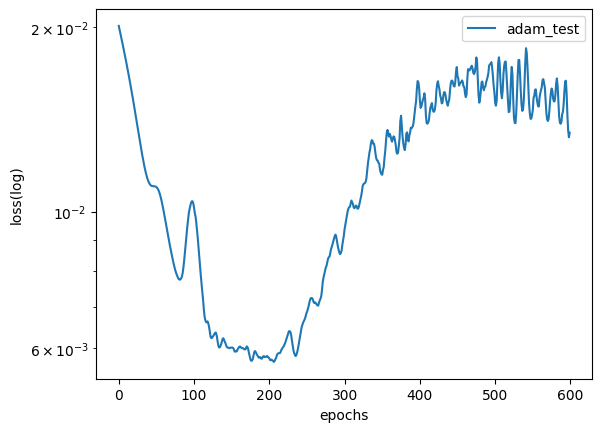

In [15]:
fig = plt.figure()
ax = fig.add_subplot()
# 学習曲線
# ax.plot(history.history["loss"], label = "train")
# 活性化関数tanhで学習した後のtanh_test
# ax.plot(history.history["val_loss"], label = "tanh_test")
# ax.plot(relu_history.history["val_loss"], label = "relu_test")
# ax.plot(sigmoid_history.history["val_loss"], label = "sigmoid_test")

ax.plot(history.history["val_loss"], label = "adam_test")
# ax.plot(adam_history.history["val_loss"], label = "adam_test")

ax.set_yscale('log')
ax.legend()
ax.set_ylabel("loss(log)")
ax.set_xlabel("epochs")

In [160]:
with open("history.json", "w") as f:
    json.dump(history.history, f)

with open("history.json", "r") as f:
    history = json.load(f)

In [162]:
history["loss"], history["val_loss"]

([0.8657496571540833,
  0.8494500517845154,
  0.8333494663238525,
  0.8174554109573364,
  0.8017687201499939,
  0.7862935066223145,
  0.7710320353507996,
  0.7559871673583984,
  0.7411612868309021,
  0.7265568971633911,
  0.712175726890564,
  0.6980196237564087,
  0.6840898990631104,
  0.6703881621360779,
  0.6569151282310486,
  0.6436717510223389,
  0.6306585073471069,
  0.6178755164146423,
  0.605323076248169,
  0.593001127243042,
  0.5809087753295898,
  0.5690460801124573,
  0.5574116706848145,
  0.5460047125816345,
  0.5348240733146667,
  0.5238682627677917,
  0.513135552406311,
  0.5026243329048157,
  0.49233278632164,
  0.4822584390640259,
  0.47239944338798523,
  0.46275320649147034,
  0.45331746339797974,
  0.4440895617008209,
  0.435066819190979,
  0.42624640464782715,
  0.4176255762577057,
  0.40920132398605347,
  0.40097057819366455,
  0.3929305672645569,
  0.38507798314094543,
  0.37740975618362427,
  0.36992284655570984,
  0.36261382699012756,
  0.35547956824302673,
  0.34

In [7]:
save_loss = list()
save_val_loss = list()
save_history = list()

#KFoldの設定
kf = KFold(n_splits = 10, shuffle = True, random_state = 1)

#交差検証
for train_index, test_index in kf.split(x, y):
    x_train = x[train_index]
    y_train = y[train_index]
    x_test = x[test_index]
    y_test = y[test_index]

    model = build_model(x)
    
    model.compile(loss=losses.MeanSquaredError(), 
              optimizer=optimizers.Adam(learning_rate = 0.0009))

    mc = callbacks.ModelCheckpoint(
        filepath = "model.h5",
        monitor = "val_loss",
        save_best_only = True,
        mode = "min"
    )

    history = model.fit(x_train, y_train, batch_size = len(x_train), epochs = 50, verbose = 1, 
                        validation_data=(x_test, y_test), callbacks =[mc])

    save_history.append(history.history)
    model = models.load_model("model.h5")
    
    best_val_loss = model.evaluate(x_test, y_test, verbose = False)

    best_loss = model.evaluate(x_train, y_train, verbose = False)

    save_val_loss.append(best_val_loss)
    save_loss.append(best_loss)

Epoch 1/600
1/1 [==============================] - 0s 481ms/step - loss: 1.5150 - val_loss: 1.5806
Epoch 2/600
1/1 [==============================] - 0s 40ms/step - loss: 1.4782 - val_loss: 1.5449
Epoch 3/600
1/1 [==============================] - 0s 40ms/step - loss: 1.4419 - val_loss: 1.5098
Epoch 4/600
1/1 [==============================] - 0s 40ms/step - loss: 1.4061 - val_loss: 1.4751
Epoch 5/600
1/1 [==============================] - 0s 41ms/step - loss: 1.3709 - val_loss: 1.4410
Epoch 6/600
1/1 [==============================] - 0s 40ms/step - loss: 1.3362 - val_loss: 1.4073
Epoch 7/600
1/1 [==============================] - 0s 49ms/step - loss: 1.3021 - val_loss: 1.3742
Epoch 8/600
1/1 [==============================] - 0s 44ms/step - loss: 1.2685 - val_loss: 1.3415
Epoch 9/600
1/1 [==============================] - 0s 46ms/step - loss: 1.2355 - val_loss: 1.3094
Epoch 10/600
1/1 [==============================] - 0s 49ms/step - loss: 1.2030 - val_loss: 1.2778
Epoch 11/600
1/1 [

Text(0.5, 0, 'epochs')

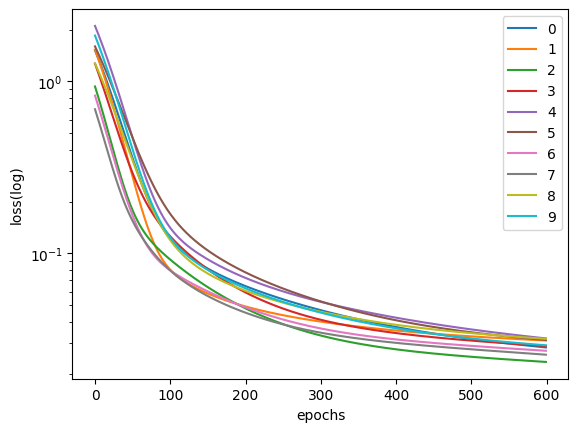

In [8]:
fig = plt.figure()
ax = fig.add_subplot()


# 学習曲線
# ax.plot(history.history["loss"], label = "train")
for i, H  in enumerate(save_history):
    H["loss"]
    # 活性化関数tanhで学習した後のtanh_test
    ax.plot(H["loss"], label = f"{i}")
    # ax.plot(H["val_loss"], label = "val_loss")

ax.set_yscale('log')
ax.legend()
ax.set_ylabel("loss(log)")
ax.set_xlabel("epochs")

In [9]:
max_save_loss = list()
min_save_loss = list()
max_save_val_loss = list()
min_save_val_loss = list()

max(save_loss), min(save_loss), max(save_val_loss), min(save_val_loss), np.average(save_loss), np.average(save_val_loss)


(0.04463426396250725,
 0.02336467243731022,
 0.112494558095932,
 0.02376248687505722,
 0.03058838061988354,
 0.05570859685540199)

In [10]:
model.evaluate(x_test, y_test, verbose = False)

0.06839665025472641

In [101]:
a = [50, 47, 51, 47, 51, 46, 50, 48, 52, 46]
sum = 0
for i in range(len(a)):
    sum += a[i] * a[i]

a_avg = np.average(a)
a_avg_tmp = a_avg * a_avg
b = sum - a_avg_tmp
b

21478.56